In [1]:
import sys
sys.path.append('..')
from NCA.trainer.NCA_trainer import NCA_Trainer
from Common.utils import load_emoji_sequence
from Common.eddie_indexer import index_to_data_nca_type
from NCA.trainer.data_augmenter_nca import DataAugmenter
from NCA.model.NCA_model import NCA
from einops import rearrange
import time
import jax
import jax.numpy as np
import optax
import matplotlib.pyplot as plt


2024-07-23 14:09:41.360969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 14:09:41.361013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 14:09:41.362466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 14:09:42.804761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Define all the variables

In [2]:
CHANNELS = 16           # How many channels to use in the model
TRAINING_STEPS = 1000   # How many steps to train for
DOWNSAMPLE = 4          # How much to downsample the image by
NCA_STEPS = 32          # How many NCA steps between each image in the data sequence

## Create a Neural Cellular Automata model
 - There are a few important parameters:
    - `KERNEL_STR` defines what sort of spatial kernels we use
    - `ACTIVATION` accepts any scalar function, acting as the neural network nonlinearity
    - `PADDING` must be "CIRCULAR", "REFLECT" , "REPLICATE" or "ZEROS" - this controls how to handle the borders of the image
    - `FIRE_RATE` must be between 0 and 1 - it is the probability of updating each pixel at each step

In [3]:
model = NCA(N_CHANNELS=CHANNELS,
            KERNEL_STR=["ID","GRAD","LAP"],
            ACTIVATION=jax.nn.relu,
            PADDING="CIRCULAR",
            FIRE_RATE=0.5)


## Load Data
 - Here we load an individual image from `demo_data/` , and create an initial condition of one seed pixel
 - `load_emoji_sequence` takes a list of strings like `["file_1","file_2",...]` and returns:
   
    an array of shape `[Batch, Timestep, Channels, Width, Height]`, where:
      - `Batch` is currently 1 - this matters more later if we want to train to multiple images at the same time
      - `Timestep` is the length of the input list
      - `Channels` is typically 3 or 4 for colour channels
      - `Width` and `Height` are for the image size

 -  We also use the `DataAugmenter` class, defined in `NCA.trainer.data_augmenter_nca.py`
    - This has a few useful functions for modifying the data during training to produce better results
    - This also adds extra hidden channels to an image
    - By creating subclasses of `DataAugmenter` we can define what behaviour to apply to data during training
         - In this example we just pad the data with extra zeros around the boundary

(Batch, Time, Channels, Width, Height): (1, 2, 4, 30, 30)


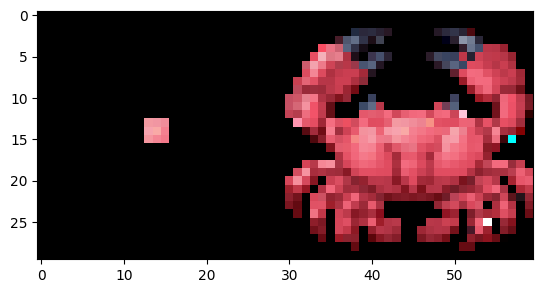

In [4]:
data = load_emoji_sequence(["crab.png"],impath_emojis="demo_data/",downsample=DOWNSAMPLE)


# For the initial condition, take a small cropped square from the middle of the target image
initial_condition = np.array(data)
W = initial_condition.shape[-2]
H = initial_condition.shape[-1]
initial_condition = initial_condition.at[0,0,:,:W//2-2].set(0)
initial_condition = initial_condition.at[0,0,:,W//2+1:].set(0)
initial_condition = initial_condition.at[0,0,:,:,:H//2-2].set(0)
initial_condition = initial_condition.at[0,0,:,:,H//2+1:].set(0)


data = np.concatenate([initial_condition,data],axis=1) # Join initial condition and data along the time axis
print("(Batch, Time, Channels, Width, Height): "+str(data.shape))
plt.imshow(rearrange(data,"() T C W H -> W (T H) C" )[...,:3])
plt.show()


class data_augmenter_subclass(DataAugmenter):
    #Redefine how data is pre-processed before training
    def data_init(self,SHARDING=None):
        data = self.return_saved_data()
        data = self.duplicate_batches(data, 1)
        data = self.pad(data, 10) 		
        self.save_data(data)
        return None
    

## Define the trainer object
- The `NCA_Trainer` takes as input the `model`, the `data` and a reference to the `DataAugmenter` class (or a custom subclass)
    - It also takes a `model_filename` for saving the output
- `NCA_Trainer` also logs a lot of training statistics using tensorboard, instructions to read that are below

In [5]:
trainer = NCA_Trainer(NCA_model=model,
                      data = data,
                      DATA_AUGMENTER=data_augmenter_subclass,
                      model_filename="test_grow_crab")

Batches = 1
Logging training to: logs/test_grow_crab/train
Saving model to: models/test_grow_crab


## Training
- Run the following code cell first, then follow these instructions to view how the training is progressing

### Evaluating training:
- In the terminal, run the following command:

`tensorboard --samples_per_plugin images=200 --logdir logs/test_grow_crab/train/`

- Where `test_grow_crab` is the model filename we supplied when defining the `NCA_Trainer`

- Then, open your browser and go to: `http://localhost:6006/`

In [6]:
trainer.train(t=NCA_STEPS,iters=TRAINING_STEPS,LOOP_AUTODIFF="lax")

  7%|▋         | 66/1000 [00:55<10:48,  1.44it/s] 

--- Model saved at 65 epochs with loss 0.09074513 ---


  7%|▋         | 69/1000 [00:57<11:23,  1.36it/s]

--- Model saved at 68 epochs with loss 0.090129174 ---


  7%|▋         | 72/1000 [00:59<12:35,  1.23it/s]

--- Model saved at 71 epochs with loss 0.08977846 ---


  8%|▊         | 77/1000 [01:03<11:54,  1.29it/s]

--- Model saved at 76 epochs with loss 0.08947158 ---


  8%|▊         | 78/1000 [01:04<11:40,  1.32it/s]

--- Model saved at 77 epochs with loss 0.08926425 ---


  8%|▊         | 79/1000 [01:05<11:18,  1.36it/s]

--- Model saved at 78 epochs with loss 0.08924552 ---


  8%|▊         | 80/1000 [01:05<11:04,  1.38it/s]

--- Model saved at 79 epochs with loss 0.08887675 ---


  8%|▊         | 81/1000 [01:08<17:19,  1.13s/it]

--- Model saved at 80 epochs with loss 0.088579655 ---


  8%|▊         | 83/1000 [01:09<14:04,  1.09it/s]

--- Model saved at 82 epochs with loss 0.0884426 ---


  8%|▊         | 85/1000 [01:10<12:14,  1.25it/s]

--- Model saved at 84 epochs with loss 0.087718084 ---


  9%|▉         | 94/1000 [01:17<10:22,  1.46it/s]

--- Model saved at 93 epochs with loss 0.087067425 ---


 10%|▉         | 96/1000 [01:18<10:18,  1.46it/s]

--- Model saved at 95 epochs with loss 0.086690985 ---


 10%|▉         | 97/1000 [01:19<10:23,  1.45it/s]

--- Model saved at 96 epochs with loss 0.086445786 ---


 10%|▉         | 99/1000 [01:20<10:20,  1.45it/s]

--- Model saved at 98 epochs with loss 0.08630968 ---


 11%|█         | 107/1000 [01:26<11:13,  1.33it/s]

--- Model saved at 106 epochs with loss 0.08578965 ---


 12%|█▏        | 115/1000 [01:34<14:11,  1.04it/s]

--- Model saved at 114 epochs with loss 0.0855935 ---


 12%|█▏        | 116/1000 [01:35<16:16,  1.10s/it]

--- Model saved at 115 epochs with loss 0.08540885 ---
